In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Loading the Boston housing dataset

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


### A look at the data

In [3]:
print('Train data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)
print(train_targets[:10])

Train data shape:  (404, 13)
Test data shape:  (102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]


## Normalizing the data

In [4]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean
train_data /= std
test_data -= mean
test_data /= std

## Model Definition

In [5]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) 
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## K-fold validation

In [6]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i+1)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
    axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
    axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets)
    all_scores.append(val_mae)

processing fold # 1
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
101/101 [==============================] - 0s 277us/step
processing fold # 2
101/101 [==============================] - 0s 326us/step
processing fold # 3
101/101 [==============================] - 0s 396us/step
processing fold # 4
101/101 [==============================] - 0s 485us/step


In [7]:
print(all_scores)
print(np.mean(all_scores))

[2.0956787838794217, 2.220593797098292, 2.859968412040484, 2.40535704039111]
2.3953995083523267


In [9]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i+1)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
    axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
    axis=0)
    
    model = build_model()
    fit_result = model.fit(partial_train_data, partial_train_targets,
              validation_data=(val_data, val_targets),
              epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = fit_result.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


## Building the history of successive mean K-fold validation score

In [15]:
average_mae_history = [
    np.mean(
        [x[i] for x in all_mae_histories]) for i in range(num_epochs)]

## Plotting validation scores

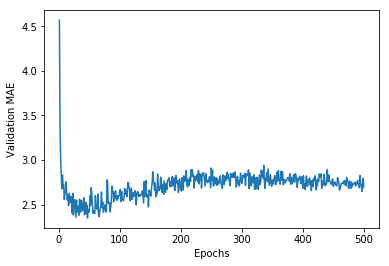

In [20]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## Plotting validation scores, excluding the first 10 data points

In [23]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

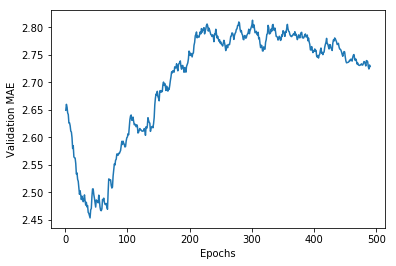

In [24]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## Training the final model

In [ ]:
model = build_model
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)